In [1]:
import io
import ipywidgets as widgets
import matplotlib.pyplot as plt
import PIL.Image
import numpy as np
import urllib
from skimage.transform import resize
from matplotlib.image import imread
import os
from IPython.display import display
from skimage import io as io_url
import cv2
import numpy as np
from PIL import Image

In [2]:
# Create image widgets
image3_spatial = widgets.Image(format='png', width=500, height=500, description='Spatial')
image3_freq    = widgets.Image(format='png', width=500, height=500, description='Frequency')
sidebyside     = widgets.HBox([image3_spatial, image3_freq])

# Create slider/select widgets
slider_inner   = widgets.FloatSlider(value=0,      min=0, max=1,      step=0.01, description='Inner radius')
slider_outer   = widgets.FloatSlider(value=1.44/2, min=0, max=1.44/2, step=0.01, description='Outer radius')

buf            = io.BytesIO()

orig_img = io_url.imread('https://img2.zergnet.com/2309662_300.jpg')
orig_img = np.mean(orig_img, -1)

x = np.fft.fftfreq(orig_img.shape[0]);
y = np.fft.fftfreq(orig_img.shape[1]);

xv, yv = np.meshgrid(x, y)
xv = np.fft.fftshift(xv)
yv = np.fft.fftshift(yv)

def filter_frequency(orig_img, mask):
    # Perform the FFT
    F_orig = np.fft.fft2(orig_img)
    F_orig_shifted = np.fft.fftshift(F_orig)

    # Apply the mask
    F_masked = F_orig_shifted * mask

    # Inverse FFT to get the spatial domain image
    F_ifft_shifted = np.fft.ifftshift(F_masked)
    img_filtered = np.fft.ifft2(F_ifft_shifted)

    # Return the absolute values of the transformed image and the masked frequency image
    return np.abs(F_masked), np.abs(img_filtered)


def on_value_change3(change):
    mask = (np.sqrt(xv**2 + yv**2) < slider_outer.value) & \
           (np.sqrt(xv**2 + yv**2) >= slider_inner.value)
    mask = np.float32(mask)

    fimg, img = filter_frequency(orig_img, mask)
    buf.seek(0)
    tmp = PIL.Image.fromarray(255*img/(img.max()+0.0001))
    tmp = tmp.convert('L')
    tmp.save(buf, 'png')
    image3_spatial.value = buf.getvalue()

    buf.seek(0)
    tmp = PIL.Image.fromarray(255*np.log(0.0001*fimg + 1))
    tmp = tmp.convert('L')
    tmp.save(buf, 'png')
    image3_freq.value = buf.getvalue()


slider_inner.observe(on_value_change3, names='value')
slider_outer.observe(on_value_change3, names='value')

on_value_change3(0)

display(sidebyside)
display(slider_inner)
display(slider_outer)

FloatSlider(value=0.0, description='Inner radius', max=1.0, step=0.01)

FloatSlider(value=0.72, description='Outer radius', max=0.72, step=0.01)

In [3]:
import cv2

def read_img(img_path, img_size=(512, 512)):
    """
    Read an image from the specified path, convert it to grayscale, and resize it.

    Params:
        img_path: str, the path to the image file.
        img_size: tuple, the target size of the image as (width, height).

    Returns:
        img: numpy ndarray, the resized grayscale image.

    Raises:
        FileNotFoundError: if the image file cannot be found at the specified path.
        Exception: for other issues that might occur during the image processing.
    """
    # Check if the file exists
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"No file found at the specified path: {img_path}")

    # Attempt to read and process the image
    try:
        # Read the image in grayscale mode
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Check if the image was read correctly
        if img is None:
            raise ValueError("Failed to read the image. The file may not be a valid image.")

        # Resize the image
        img = cv2.resize(img, img_size)
        return img
    except Exception as e:
        raise Exception(f"An error occurred while processing the image: {str(e)}")



def create_hybrid_img(img1, img2, r):
    # Transform both images to frequency domain
    F1 = np.fft.fft2(img1)
    F2 = np.fft.fft2(img2)
    F1_shifted = np.fft.fftshift(F1)
    F2_shifted = np.fft.fftshift(F2)

    # Create a low-pass filter mask for img1
    rows, cols = img1.shape
    crow, ccol = rows // 2, cols // 2
    mask_low = np.zeros((rows, cols), dtype=np.float32)
    mask_low[crow-r:crow+r, ccol-r:ccol+r] = 1

    # Create a high-pass filter mask for img2
    mask_high = 1 - mask_low

    # Apply masks
    F1_low = F1_shifted * mask_low
    F2_high = F2_shifted * mask_high

    # Combine the frequencies
    hybrid_F = F1_low + F2_high

    # Transform back to spatial domain
    hybrid_F_ifftshift = np.fft.ifftshift(hybrid_F)
    hybrid_img = np.fft.ifft2(hybrid_F_ifftshift)

    # Return the absolute value of the hybrid image
    return np.abs(hybrid_img)


(-0.5, 511.5, 511.5, -0.5)

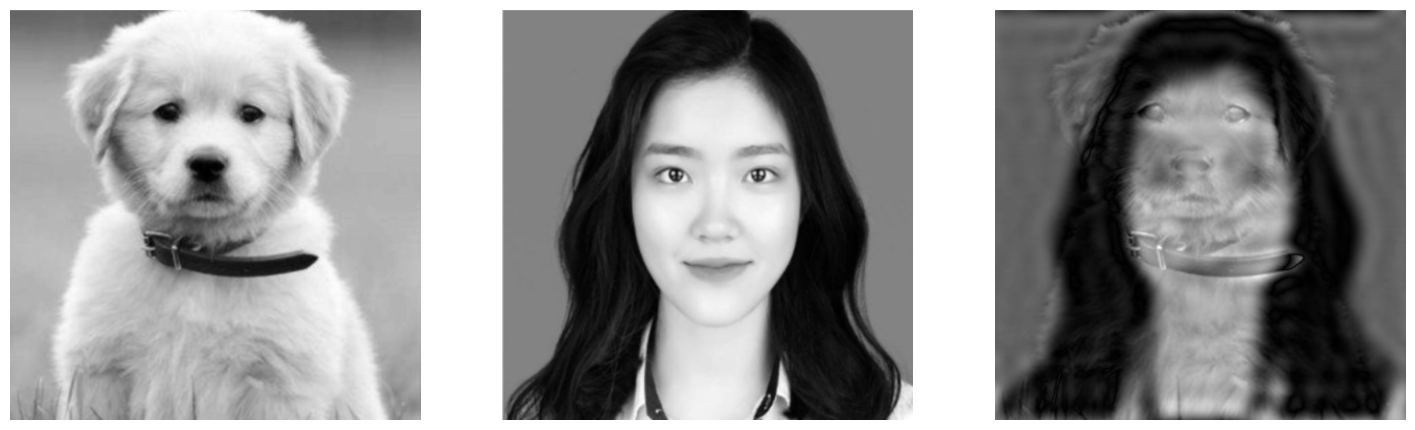

In [6]:
image_1_path = "image1.png" # <-- need to change
image_2_path = "image2.png" # <-- need to change
img_1 = read_img(image_1_path)
img_2 = read_img(image_2_path)
hybrid_img = create_hybrid_img(img_2, img_1, 14)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 15))
axes[0].imshow(img_1, cmap="gray")
axes[0].axis("off")
axes[1].imshow(img_2, cmap="gray")
axes[1].axis("off")
axes[2].imshow(hybrid_img, cmap="gray")
axes[2].axis("off")